In [ ]:
! pip install wget
import wget

url = 'https://github.com/dirkhovy/NLPclass/blob/master/data/reviews.xlsx?raw=true'
wget.download(url, 'reviews.xlsx')

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=8e401a5ebe097ca27e6a539e5d06d2317606a0f75d86caa6d6741f064c29c35b
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'reviews.xlsx'

# Latent Dimensions I: Matrix Factorization

First, we need some data. Let's get a bunch of reviews

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# read in the data and transform it
df = pd.read_excel('reviews.xlsx', nrows=100000)
df = df[df.clean_text.isna()==False] # drop all reviews without clean text
documents = df.clean_text.apply(str).tolist() # make sure they are strings

In [ ]:
df.head()

,Unnamed: 0,category,text,clean_text
0,0,Beauty and Wellness,there was an issue with the delivery but this ...,issue delivery resolve quickly complete care s...
1,1,Computer & Accessories,i found the item i was looking for quickly on ...,find item look quickly web site place order to...
2,2,Bathroom,part ordered monday pm and received it next day .,order monday pm receive day
3,3,Cell phone Recycling,the day the phone was received i had the money...,day phone receive money bank
4,4,Flowers,"flowers were beautiful , delivered on time and...",flower beautiful deliver time notify progress ...


In [ ]:
documents[0:10]

['issue delivery resolve quickly complete care shop aware',
 'find item look quickly web site place order tool couple min memory day 0st class delivery option special delivery',
 'order monday pm receive day',
 'day phone receive money bank',
 'flower beautiful deliver time notify progress order step way',
 'second time serenata flower pleased recent purchase thank',
 "n't know expect order keep fully date order",
 "glad n't result search engine cheap price buying experience mrmemory prove excellent product exactly describe fair price",
 'card past week good value money accompany sound delivery laptop definately use gizzmo heaven',
 'simple easy follow site provide extremely competitive price locate tire choose fitting day order minute']

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(99973, 2444)


## SVD

SVD decomposes the data into three components: the document view `U`, the singular values `S`, and the term view `V`.

In [ ]:
from sklearn.decomposition import TruncatedSVD # this also works with sparse matrices

# set number of latent components
k = 20

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

CPU times: user 1.75 s, sys: 1.1 s, total: 2.85 s
Wall time: 1.59 s


In [ ]:
print(U.shape, S.shape, V.shape)

(99973, 20) (20,) (20, 2444)


In [ ]:
S # important score of each concept

array([50.31098776, 31.33086583, 29.01518027, 26.78100881, 25.55984111,
       25.05466644, 23.92824215, 22.64218788, 22.05456944, 21.8785322 ,
       21.6315678 , 20.64842314, 20.51701227, 20.17425094, 20.09426021,
       19.59972335, 19.35640173, 18.92161036, 18.83797762, 18.55548062])

## NMF

NMF provides only two components: the document view `W`, and the term view `H`.

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=k, init='nndsvd', random_state=0)
# random state = make the result deterministic
# otherwise everytime we will have a different result

%time W = nmf.fit_transform(X)
H = nmf.components_

CPU times: user 44.8 s, sys: 27.5 s, total: 1min 12s
Wall time: 41.1 s


In [ ]:
print(W.shape, H.shape)

(99973, 20) (20, 2444)


## Latent topics

We can use the term views `V` (from SVD) and `H` (from NMF) to describe the latent concept dimensions.

In [ ]:
import numpy as np
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A]) # for each row
    return [', '.join(t) for t in topic_words]


In [ ]:
V.shape

(20, 2444)

In [ ]:
t = V[0] # first row corresponds to the first concept
topn = 5
vocabulary = tfidf_vectorizer.get_feature_names() # get vocabulary
[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
# take the terms corrisponding to the highest values in t by terms indexes


# t[1937]
# t[2366]

# we obtain the first 5 terms most likely associated to the first concept

['service', 'order', 'good', 'day', 'price']

Here are the terms from SVD:

In [ ]:
terms = tfidf_vectorizer.get_feature_names()

show_topics(V, terms)

['service, order, good, day, price',
 'phone, send, day, money, mazuma',
 'order, flower, deliver, day, arrive',
 'easy, use, easy use, website, flower',
 'service, flower, excellent, fast, great',
 'tyre, service, fit, time, recommend',
 'flower, good, good price, price, deliver',
 'great, delivery, tyre, fast, fast delivery',
 'quick, service, easy, excellent, quick delivery',
 'great, great service, great price, quickly, product',
 'quick, recommend, quick delivery, great, product',
 'time, fast, quickly, mazuma, sell',
 'product, money, excellent, value, value money',
 'arrive, money, time, value, arrive day',
 'order, deliver, money, value, value money',
 'excellent, price, deliver, time, excellent service',
 'time, use, receive, company, product',
 'site, web, web site, time, order',
 'deliver, day, fast, deliver day, quick',
 'product, easy, order, mobile, mazuma']

… and the ones from NMF

In [ ]:
show_topics(H, terms)

['good, price, good price, price good, good service',
 'phone, send, mazuma, sell, old',
 'order, place, place order, easy order, morning',
 'easy, use, easy use, website, website easy',
 'service, customer, customer service, good service, efficient',
 'tyre, fit, tyre fit, fitting, fitter',
 'flower, beautiful, lovely, serenata, order flower',
 'fast, delivery, fast delivery, price fast, fast efficient',
 'recommend, friend, company, highly, definitely',
 'great, great service, great price, price, service great',
 'quick, quick delivery, delivery, quick easy, service quick',
 'time, ve, arrive time, second, delivery time',
 'buy, cheap, need, shop, look',
 'money, account, bank, money account, money bank',
 'day, receive, arrive day, later, day later',
 'excellent, excellent service, service, service excellent, excellent price',
 'arrive, quickly, arrive quickly, item, arrive day',
 'site, web, web site, site easy, use site',
 'deliver, deliver day, deliver time, deliver quickly, orde

## Visualization

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('spring') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
#     plt.legend()
    plt.show()

First, we create 3-dimensional document embeddings with both methods:

In [ ]:
low_dim_svd = TruncatedSVD(n_components=3) # need few components to be able to plot
low_dim_nmf = NMF(n_components=3, init='nndsvd')

# let's visualize only the first 200 documents
Z = X[:200]
categories = df.category[:200]

low_dim_U = low_dim_svd.fit_transform(Z)
low_dim_W = low_dim_nmf.fit_transform(Z)

In [ ]:
df.category.value_counts()
# Pets is not observed in the previous list of 20 topics maybe because people
# don't speak about pets by using the word 'pet'

Cell phone Recycling        21283
Flowers                     13828
Pets                        11210
Tires                       10250
Beauty and Wellness         10199
Fashion Accessories          9844
Batteries & Power Supply     6080
Bathroom                     5995
Gifts                        5687
Computer & Accessories       5597
Name: category, dtype: int64

Here is what SVD looks like:

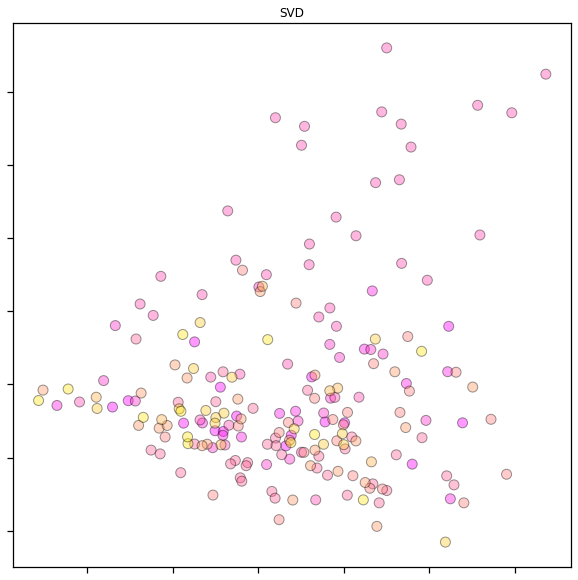

In [ ]:
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=2)

And here is NMF's version:

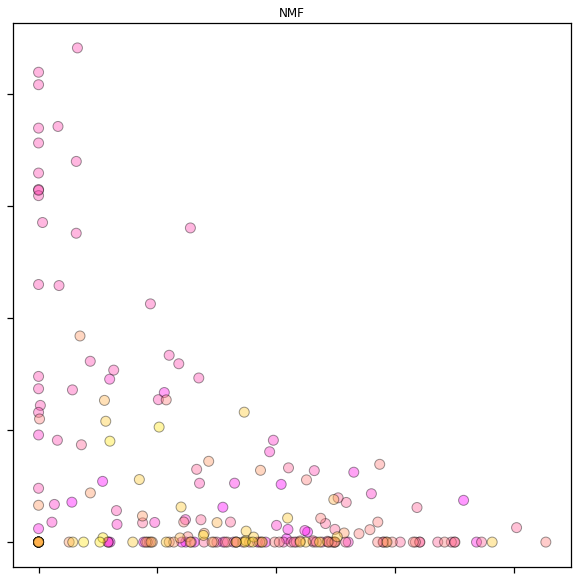

In [ ]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=2)

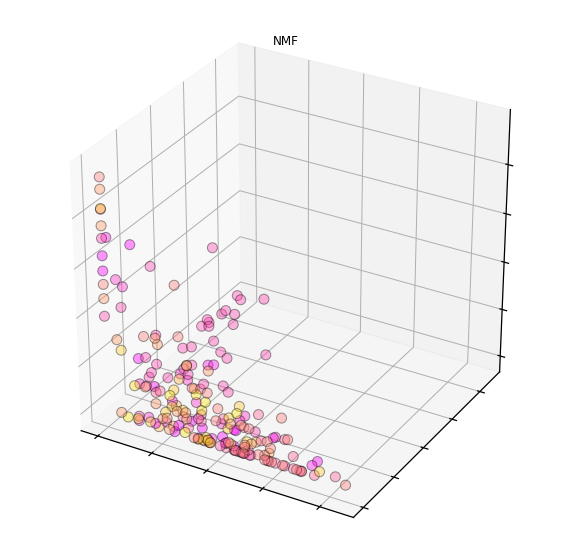

In [ ]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=3)

# Exercise

Plot data using TSNE

In [ ]:
?TSNE

Object `TSNE` not found.


In [ ]:
from sklearn.manifold import TSNE

low_dim_tsne = TSNE(n_components=3)
low_dim = low_dim_tsne.fit_transform(Z)

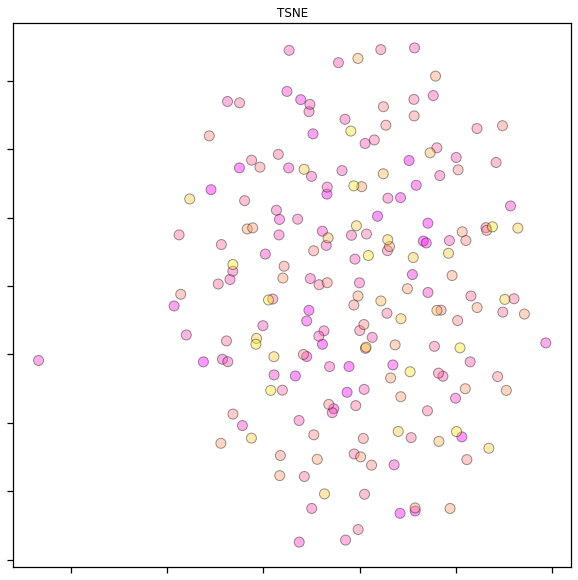

In [ ]:
plot_vectors(low_dim, title='TSNE', labels=categories, dimensions=2)
# mixed result
# for sparsity we should use SVD and NMF
# for embeddings use TSNE

# Latent Dimensions II: Clustering

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering

k = 16

# reduce the dimensionality of the input, to speed up clustering
%time X2 = TruncatedSVD(n_components=300).fit_transform(X)

agg = AgglomerativeClustering(n_clusters=k)

CPU times: user 24.1 s, sys: 3.58 s, total: 27.7 s
Wall time: 19.1 s


Let's start clustering with a random sample of points:

In [ ]:
sample = np.random.choice(len(X2), replace=False, size=8000)
%time agg_sample_ids = agg.fit_predict(X2[sample])

CPU times: user 10.8 s, sys: 37.6 ms, total: 10.9 s
Wall time: 10.8 s


In [ ]:
agg_sample_ids # each instance to a cluster

array([3, 0, 0, ..., 5, 3, 0])

We can get the best of both worlds by initializing k-means with centroids we found from agglomerative clustering. First, let's get the centroid/average of each cluster:

In [ ]:
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape) # 16 centroinds with size 300 

(16, 300)


In [ ]:
centroids

array([[ 1.39230257e-01, -1.44952071e-02,  2.15076819e-02, ...,
        -2.17621491e-04,  6.88037221e-04, -1.25119155e-03],
       [ 1.68966547e-01, -5.21124156e-02, -6.45156731e-02, ...,
         5.10080769e-03,  3.52407389e-03,  4.97561347e-03],
       [ 1.60687178e-01, -1.69144129e-02, -3.12335056e-02, ...,
         2.90940540e-04, -3.26497466e-03,  1.64623516e-03],
       ...,
       [ 1.40103224e-01, -2.74076114e-02,  1.51369803e-02, ...,
        -5.63055104e-03,  6.07455845e-03, -3.73149558e-04],
       [ 1.30256370e-01, -9.77601421e-03,  3.79819129e-02, ...,
         3.02995975e-04, -5.87590441e-04, -1.28800976e-03],
       [ 2.09006522e-01, -4.56905213e-02, -1.35729952e-01, ...,
        -5.75389741e-05,  9.97204751e-05,  3.98033584e-03]])

Now we can initialize the k-means algorithm with the agglomerative cluster centroids as starting points:

In [ ]:
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

# fit it on the full 300-dimensional data set
%time km.fit(X2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  """Entry point for launching an IPython kernel.


CPU times: user 435 ms, sys: 243 ms, total: 678 ms
Wall time: 6.09 s


KMeans(algorithm='auto', copy_x=True,
       init=array([[ 1.39230257e-01, -1.44952071e-02,  2.15076819e-02, ...,
        -2.17621491e-04,  6.88037221e-04, -1.25119155e-03],
       [ 1.68966547e-01, -5.21124156e-02, -6.45156731e-02, ...,
         5.10080769e-03,  3.52407389e-03,  4.97561347e-03],
       [ 1.60687178e-01, -1.69144129e-02, -3.12335056e-02, ...,
         2.90940540e-04, -3.26497466e-03,  1.64623516e-03],
       ...,
       [ 1...
        -5.63055104e-03,  6.07455845e-03, -3.73149558e-04],
       [ 1.30256370e-01, -9.77601421e-03,  3.79819129e-02, ...,
         3.02995975e-04, -5.87590441e-04, -1.28800976e-03],
       [ 2.09006522e-01, -4.56905213e-02, -1.35729952e-01, ...,
        -5.75389741e-05,  9.97204751e-05,  3.98033584e-03]]),
       max_iter=300, n_clusters=16, n_init=10, n_jobs=-1,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

We can now use the cluster IDs to plot the data in three dimensions:

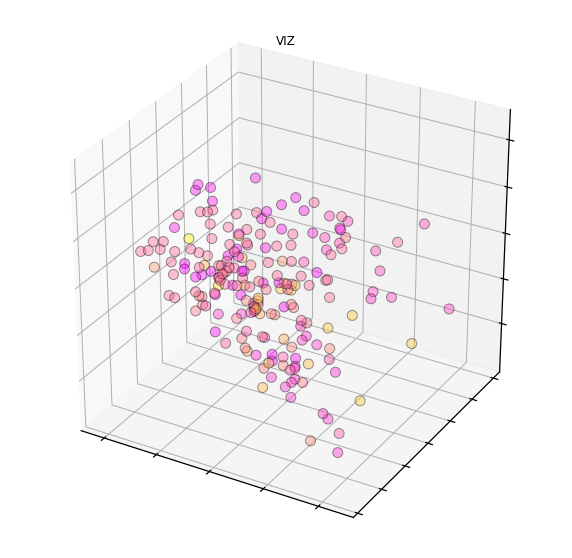

In [ ]:
plot_sample = np.random.choice(len(X2), replace=False, size=200)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

… and in two dimensions:

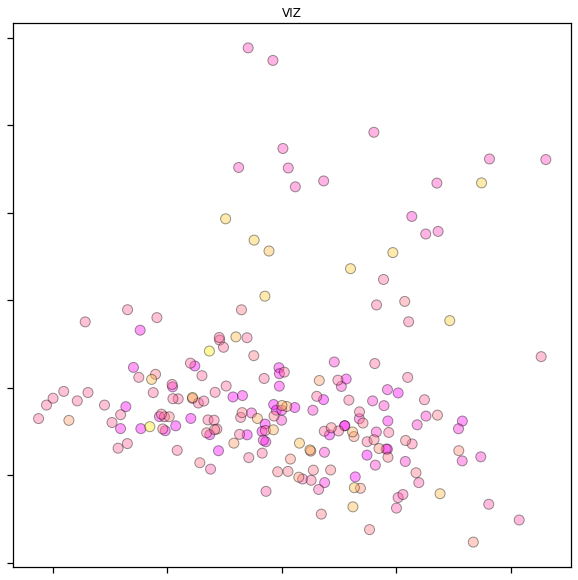

In [ ]:
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=2)

Compare that to the sample we used for agglomerative clustering:

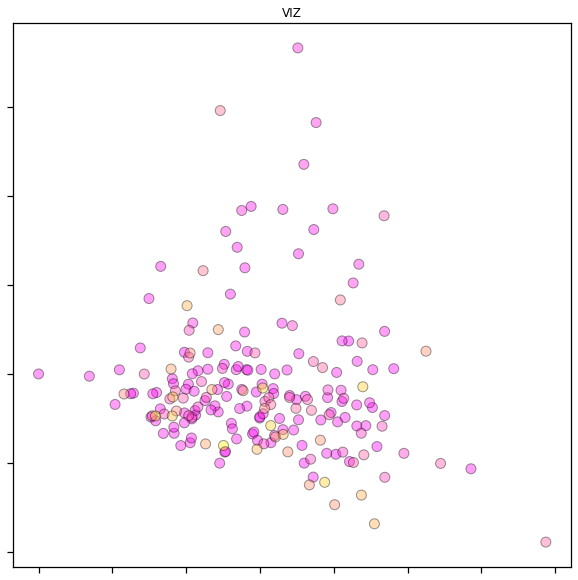

In [ ]:
plot_vectors(X2[sample[:200]], labels=agg_sample_ids[:200], dimensions=2)

## Evaluating clusters


20 0.01435464449761136
21 0.01482102411505481
22 0.015687747480675758
23 0.016324905827582777
24 0.01571222552748869
25 0.009878238523544088


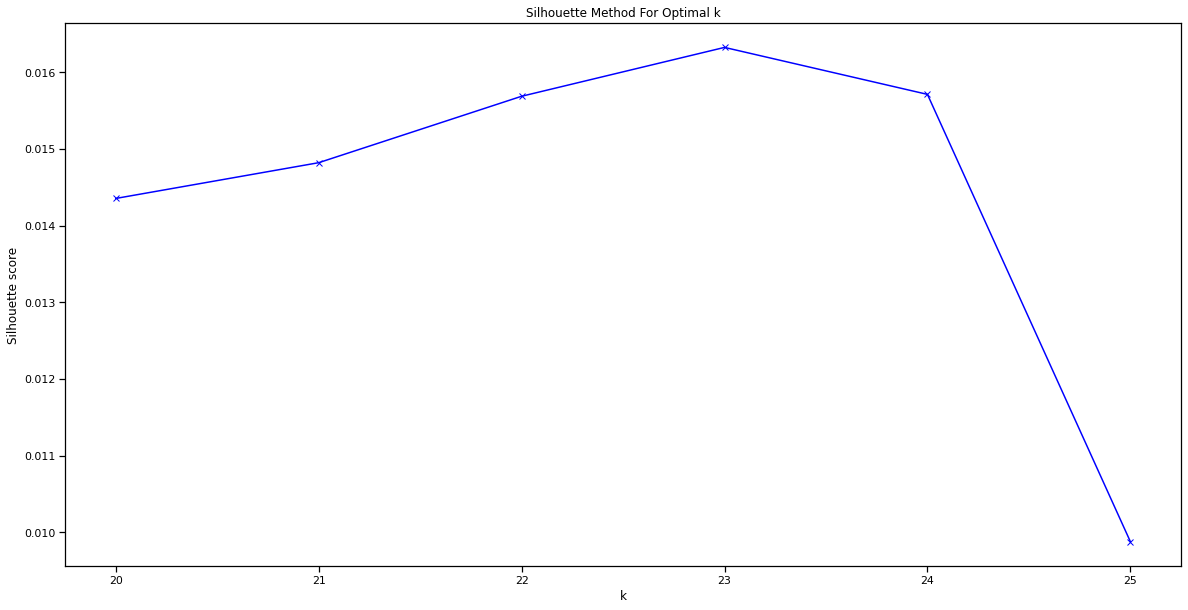

In [ ]:
from sklearn.metrics import silhouette_score

silhouettes = []

K = range(20, 26)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])
#     agg_centroids = np.array([X2[[i for i, v in enumerate(agg_cluster_ids) if v == k]].mean(axis=0) 
#                            for k in range(c)])

#     kmeans_clustering = KMeans(n_clusters=c, n_jobs=-1, init=agg_centroids)
#     kmeans_ids = kmeans_clustering.fit_predict(X2)
    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

# 22 is the best choise seens it has the highest silhouette score

## Clustering metrics

The [sklearn.metrics.cluster](
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.cluster) submodule contains evaluation metrics for cluster analysis results. There are two forms of evaluation:

- **supervised**, which uses a ground truth class values for each sample.
- **unsupervised**, which does not and measures the ‘quality’ of the model itself.


## Supervised Evaluation Metrics

V-measure can be used to compare the clustering results with the existing class labels of data points or with the alternative clustering. It is defined as the harmonic mean of **homogeneity** (h) and **completeness** (c) of the clustering:
$.$


<div>\[V_{\beta} = (1+\beta)\frac{h \cdot c}{\beta \cdot h + c}.\]</div>


In particular Rosenberg and Hirschberg (2007) define the following two desirable objectives for any cluster assignment:

- **homogeneity** (h): each cluster contains only members of a single class.
- **completeness** (c): all members of a given class are assigned to the same cluster.





<img src="https://image.slidesharecdn.com/clustering-180227115834/95/cluster-analysis-assignment-update-81-638.jpg?cb=1521519008" width="50%">


<img src="https://image.slidesharecdn.com/clustering-180227115834/95/cluster-analysis-assignment-update-82-638.jpg?cb=1521519008" width="50%">


### Import Data and Preprocessing


In [ ]:
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
iris

In [ ]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

## PCA


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca_transformed = pca.fit_transform(X_scaled)
pca_transformed

array([[-6.30702931e-01,  1.07577910e-01],
       [-6.22904943e-01, -1.04259833e-01],
       [-6.69520395e-01, -5.14170597e-02],
       [-6.54152759e-01, -1.02884871e-01],
       [-6.48788056e-01,  1.33487576e-01],
       [-5.35272778e-01,  2.89615724e-01],
       [-6.56537790e-01,  1.07244911e-02],
       [-6.25780499e-01,  5.71335411e-02],
       [-6.75643504e-01, -2.00703283e-01],
       [-6.45644619e-01, -6.72080097e-02],
       [-5.97408238e-01,  2.17151953e-01],
       [-6.38943190e-01,  3.25988375e-02],
       [-6.61612593e-01, -1.15605495e-01],
       [-7.51967943e-01, -1.71313322e-01],
       [-6.00371589e-01,  3.80240692e-01],
       [-5.52157227e-01,  5.15255982e-01],
       [-5.77053593e-01,  2.93709492e-01],
       [-6.03799228e-01,  1.07167941e-01],
       [-5.20483461e-01,  2.87627289e-01],
       [-6.12197555e-01,  2.19140388e-01],
       [-5.57674300e-01,  1.02109180e-01],
       [-5.79012675e-01,  1.81065123e-01],
       [-7.37784662e-01,  9.05588211e-02],
       [-5.

## Plot

In [ ]:
def plot3clusters(X, title, vtitle):
  plt.figure()
  colors = ['navy', 'turquoise', 'darkorange']
  lw = 2

  for color, i, target_name in zip(colors, [0, 1, 2], target_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=1., lw=lw,
                  label=target_name)
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)  
  plt.xlabel(vtitle + "1")
  plt.ylabel(vtitle + "2")
  plt.show()

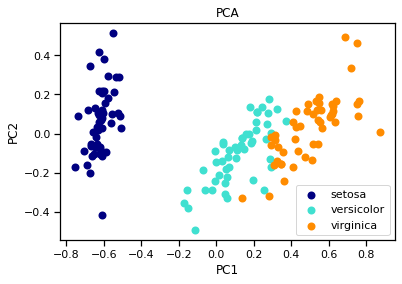

In [ ]:
plot3clusters(pca_transformed[:,:2], 'PCA', 'PC')  

# Exercise

1. Compute SVD and NNMF on Iris dataset
2. Compute K-means and agglomerative clustering to obtain labels
3. For each combination, evaluate homogeneity, completeness and v_measure

Return a table with metrics and dimensionality reduction algorithm and clustering algorithm

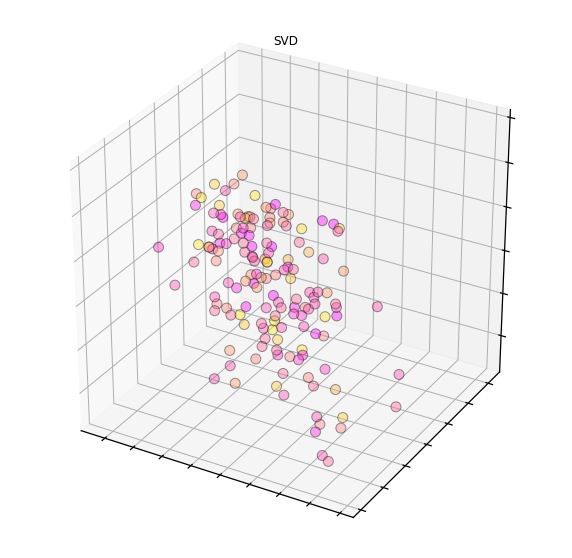

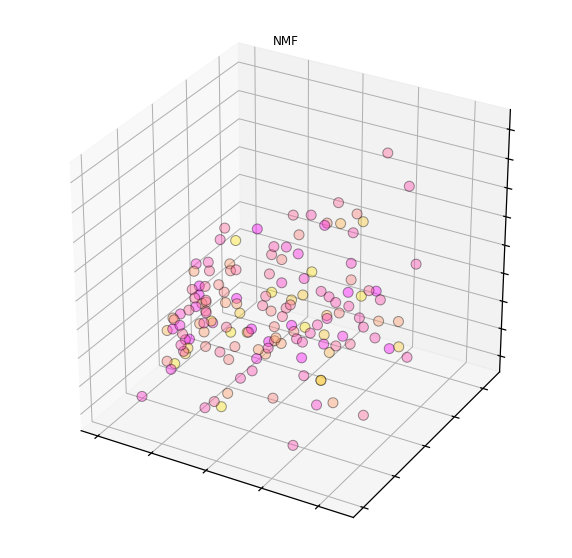

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
 
low_dim_svd = TruncatedSVD(n_components=3)
low_dim_nmf = NMF(n_components=3, init='nndsvd')
low_dim_U = low_dim_svd.fit_transform(X_scaled)
low_dim_W = low_dim_nmf.fit_transform(X_scaled)
 
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=3)
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=3)

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np

c=4
agg_clustering = AgglomerativeClustering(n_clusters=c)
sample = np.random.choice(len(X_scaled), replace=False, size=len(X_scaled))
agg_cluster_ids = agg_clustering.fit_predict(X_scaled[sample,:])
agg_centroids = np.array([X_scaled[[i for i, v in enumerate(agg_cluster_ids) if v == k],:].mean(axis=0) 
 for k in range(c)])
 
kmeans_clustering = KMeans(n_clusters=c, n_jobs=-1, init=agg_centroids)
kmeans_ids = kmeans_clustering.fit_predict(X_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return self.fit(X, sample_weight=sample_weight).labels_


In [ ]:
from sklearn.metrics import homogeneity_completeness_v_measure
homogeneity_completeness_v_measure(y, agg_cluster_ids)

(0.011388021168584506, 0.009533725434748381, 0.01037870012717691)